<a href="https://colab.research.google.com/github/mccoymb/AAE-590-DSMM/blob/main/590DSMM_HW2_Found_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

# Load using numpy.load() first to inspect contents
data = np.load('/content/drive/My Drive/590TrainingData/train.npz')

# Print stored variable names
print("Keys in npz file:", data.files)
# Load dataset
input_raw_data = data['input_raw_data']  # Shape: (200000, 1, 64, 64)

Keys in npz file: ['clips', 'dims', 'input_raw_data']


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# Time sequence (repeats for each sequence)
time_values = np.array([25000, 28000, 31000, 35000, 37500, 40000, 45000, 50000, 75000, 108000,
                        180000, 220000, 250000, 270000, 300000, 360000, 430000, 540000, 900000, 1080000])

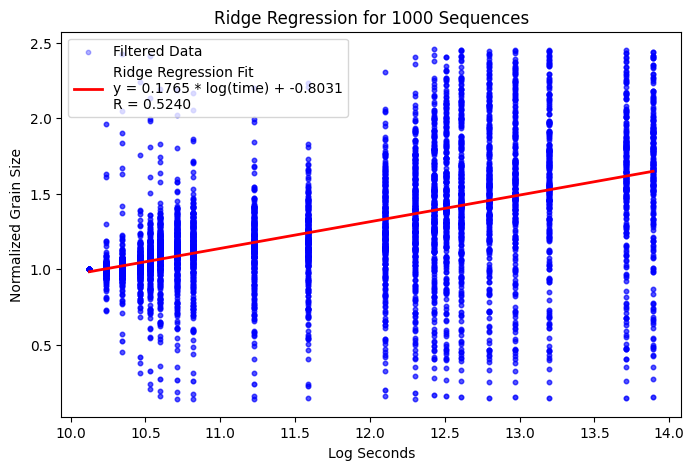

Regression Equation: y = 0.1765 * log(time) + -0.8031
R = 0.5240


In [10]:
num_sequences = 1000
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))  # Shape (1000, 20)

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)  # If too small, set a minimum threshold

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size

# Flatten the arrays to have one grain size per image with corresponding time
X_log_time = np.tile(np.log(time_values), num_sequences)  # Repeat time values for each sequence
Y_grain_sizes = all_grain_sizes.flatten()  # Flatten grain size values

# ----------- OUTLIER REMOVAL (IQR Method) -----------
Q1 = np.percentile(Y_grain_sizes, 25)  # 25th percentile
Q3 = np.percentile(Y_grain_sizes, 75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = ridge.coef_[0]
intercept = ridge.intercept_

# Predict and calculate R-value
predicted_grain_sizes = ridge.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), ridge.predict(np.log(time_values).reshape(-1, 1)),
         label=f"Ridge Regression Fit\n{equation}", color="red", linewidth=2)
plt.xlabel("Log Seconds")
plt.title("Ridge Regression for 1000 Sequences")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


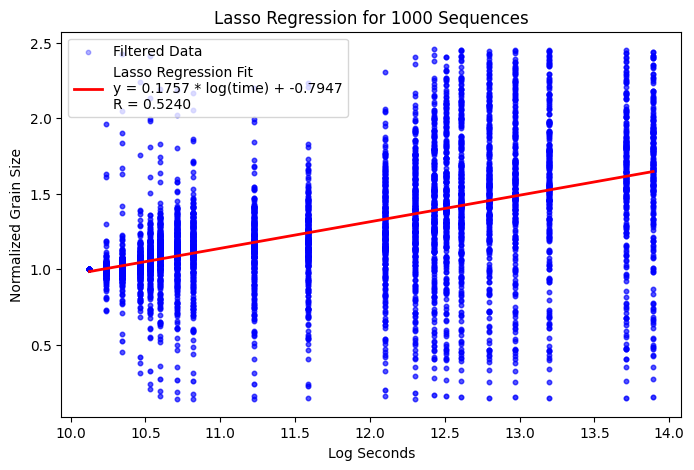

Regression Equation: y = 0.1757 * log(time) + -0.7947
R = 0.5240


In [11]:
from sklearn.linear_model import Lasso

# Train Lasso Regression with lower alpha
lasso = Lasso(alpha=0.001)
lasso.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = lasso.coef_[0]
intercept = lasso.intercept_

# Predict and calculate R-value
predicted_grain_sizes = lasso.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), lasso.predict(np.log(time_values).reshape(-1, 1)),
         label=f"Lasso Regression Fit\n{equation}", color="red", linewidth=2)
plt.xlabel("Log Seconds")
plt.title("Lasso Regression for 1000 Sequences")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


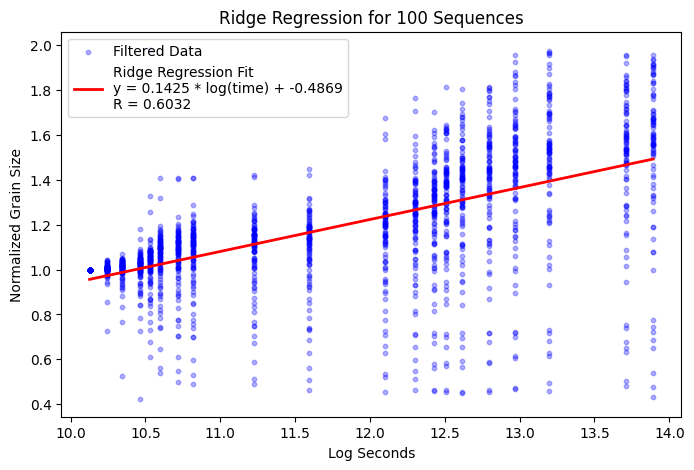

Regression Equation: y = 0.1425 * log(time) + -0.4869
R = 0.6032


In [12]:
num_sequences = 100
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))  # Shape (1000, 20)

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)  # If too small, set a minimum threshold

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size

# Flatten the arrays to have one grain size per image with corresponding time
X_log_time = np.tile(np.log(time_values), num_sequences)  # Repeat time values for each sequence
Y_grain_sizes = all_grain_sizes.flatten()  # Flatten grain size values

# ----------- OUTLIER REMOVAL (IQR Method) -----------
Q1 = np.percentile(Y_grain_sizes, 25)  # 25th percentile
Q3 = np.percentile(Y_grain_sizes, 75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = ridge.coef_[0]
intercept = ridge.intercept_

# Predict and calculate R-value
predicted_grain_sizes = ridge.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), ridge.predict(np.log(time_values).reshape(-1, 1)),
         label=f"Ridge Regression Fit\n{equation}", color="red", linewidth=2)
plt.xlabel("Log Seconds")
plt.title("Ridge Regression for 100 Sequences")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


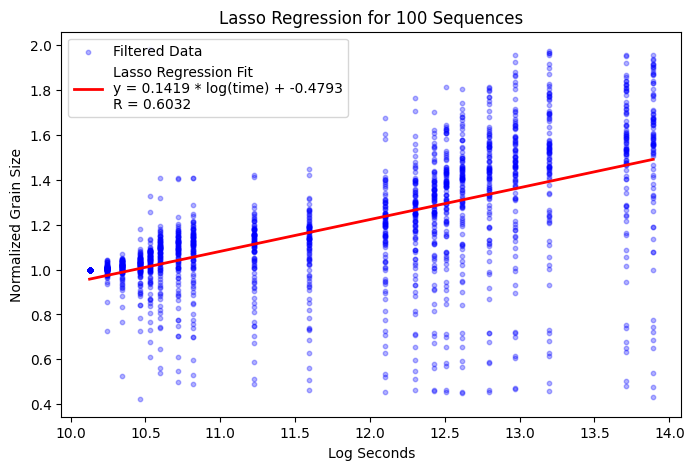

Regression Equation: y = 0.1419 * log(time) + -0.4793
R = 0.6032


In [13]:
from sklearn.linear_model import Lasso

# Train Lasso Regression with lower alpha
lasso = Lasso(alpha=0.001)
lasso.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = lasso.coef_[0]
intercept = lasso.intercept_

# Predict and calculate R-value
predicted_grain_sizes = lasso.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), lasso.predict(np.log(time_values).reshape(-1, 1)),
         label=f"Lasso Regression Fit\n{equation}", color="red", linewidth=2)
plt.xlabel("Log Seconds")
plt.title("Lasso Regression for 100 Sequences")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


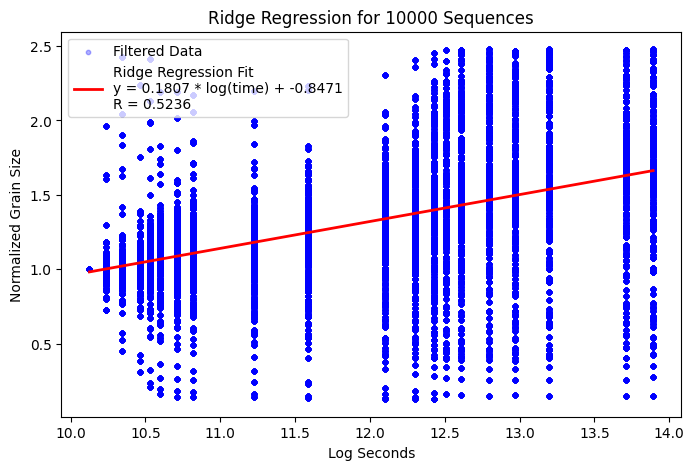

Regression Equation: y = 0.1807 * log(time) + -0.8471
R = 0.5236


In [14]:
num_sequences = 10000
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))  # Shape (1000, 20)

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)  # If too small, set a minimum threshold

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size

# Flatten the arrays to have one grain size per image with corresponding time
X_log_time = np.tile(np.log(time_values), num_sequences)  # Repeat time values for each sequence
Y_grain_sizes = all_grain_sizes.flatten()  # Flatten grain size values

# ----------- OUTLIER REMOVAL (IQR Method) -----------
Q1 = np.percentile(Y_grain_sizes, 25)  # 25th percentile
Q3 = np.percentile(Y_grain_sizes, 75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

# Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = ridge.coef_[0]
intercept = ridge.intercept_

# Predict and calculate R-value
predicted_grain_sizes = ridge.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), ridge.predict(np.log(time_values).reshape(-1, 1)),
         label=f"Ridge Regression Fit\n{equation}", color="red", linewidth=2)
plt.xlabel("Log Seconds")
plt.title("Ridge Regression for 10000 Sequences")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


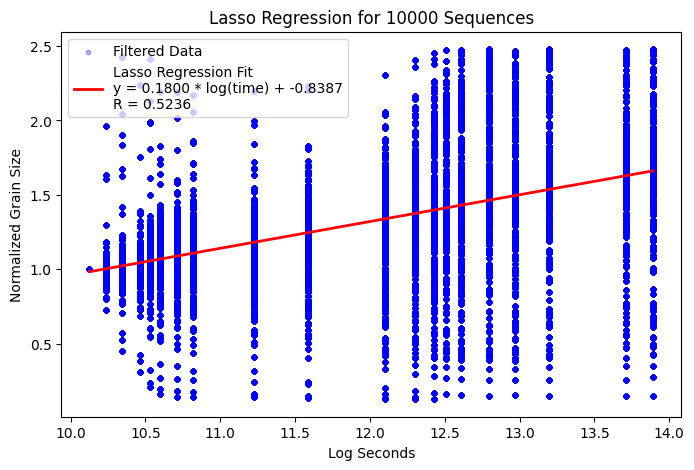

Regression Equation: y = 0.1800 * log(time) + -0.8387
R = 0.5236


In [15]:
from sklearn.linear_model import Lasso

# Train Lasso Regression with lower alpha
lasso = Lasso(alpha=0.001)
lasso.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = lasso.coef_[0]
intercept = lasso.intercept_

# Predict and calculate R-value
predicted_grain_sizes = lasso.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), lasso.predict(np.log(time_values).reshape(-1, 1)),
         label=f"Lasso Regression Fit\n{equation}", color="red", linewidth=2)
plt.xlabel("Log Seconds")
plt.title("Lasso Regression for 10000 Sequences")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)
